In [1]:
# User-defined variables
work_dir = '/Users/Tem/Documents/naturalistic-threat-ptsd'
nPerms = 10000
hemo_lag = 4

In [2]:
# Import packages 
import warnings
warnings.filterwarnings("ignore")
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import iqr
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import fdrcorrection

In [3]:
# Create directory to house classical figures
date_string = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
classical_fig_dir = f"{work_dir}/data/figures/classical-figs-{date_string}"
os.makedirs(classical_fig_dir)

(array([0.5, 1.5, 2.5]),
 [Text(0.5, 0, 'Re-experiencing'),
  Text(1.5, 0, 'Avoidance-Numbing'),
  Text(2.5, 0, 'Hyperarousal')])

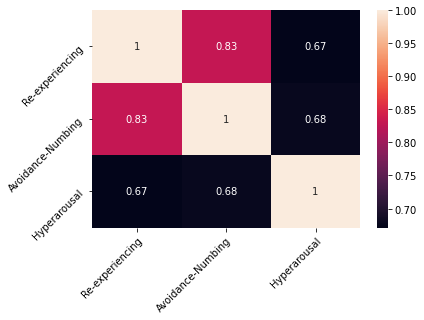

In [4]:
# Load ROI labels
amygdala_labels = pd.read_csv(f"{work_dir}/masks/amygdala-harvard-oxford/ROI-labels.csv")

# Load and visualize symptom data
CAPS_data = pd.read_csv(f"{work_dir}/data/subs/CAPS.csv")
cohort_IDs = pd.read_csv(f"{work_dir}/data/subs/cohort_IDs.csv")
nCohort = len(cohort_IDs)

symptom_labels = ['Re-experiencing', 'Avoidance-Numbing', 'Hyperarousal']

sns.heatmap(np.corrcoef(CAPS_data[symptom_labels].to_numpy(), rowvar = False), 
            xticklabels = symptom_labels,
            yticklabels = symptom_labels,
            annot = True)

plt.yticks(rotation = 45)
plt.xticks(rotation = 45, rotation_mode = 'anchor', ha = 'right') 

## Functions

In [5]:
# Define function that correlates an interSC variable with each dimension of a symptom variable
def corr_isc_symp(interSC_var, symp_var): 
    actual_corrs = [None] * len(symptom_labels)
    corr_p_vals = [None] * len(symptom_labels)
    all_null_dists = [None] * len(symptom_labels)
    
    for i in range(len(symptom_labels)):
        which_score = symptom_labels[i]
        null_dist = np.zeros(nPerms)

        # Actual r value
        x = symp_var[which_score]
        y = interSC_var
        actual_corr = stats.spearmanr(x, y)[0]
        actual_corrs[i] = actual_corr

        # Null distribution of r-values 
        for j in range(nPerms):
            x = symp_var[which_score]
            y = interSC_var[random.choices(range(nCohort), k = (nCohort))]
            null_dist[j] = stats.spearmanr(x, y)[0]
    
        perms_above_frac = len((null_dist[null_dist > actual_corr]) + 1) / (nPerms + 1)
        corr_p_vals[i] = min(2*perms_above_frac, 2*(1-perms_above_frac))
        all_null_dists[i] = null_dist
        
    return actual_corrs, corr_p_vals, all_null_dists

## Left Amygdala InterSC

In [6]:
# Load event files for stimulus onsets
all_CSminus_onsets = [None] * nCohort
all_CSplus_onsets = [None] * nCohort

for i in range(nCohort):
    day1_onsets = pd.read_csv(f"{work_dir}/data/task/events-classical/{cohort_IDs['subject'][i]}.csv")
    
    day1_CSplus = day1_onsets[day1_onsets['trial_type'].str.contains('plus') & ~day1_onsets['trial_type'].str.contains('US')].reset_index()
    CSplus_onsets = [list(range(day1_CSplus['onset'][i] + hemo_lag, day1_CSplus['onset'][i] + day1_CSplus['duration'][i] + hemo_lag)) for i in range(len(day1_CSplus))]
    all_CSplus_onsets[i] = [item for sublist in CSplus_onsets for item in sublist]

    day1_CSminus = day1_onsets[day1_onsets['trial_type'].str.contains('minus')].reset_index()
    CSminus_onsets = [list(range(day1_CSminus['onset'][i] + hemo_lag, day1_CSminus['onset'][i] + day1_CSminus['duration'][i] + hemo_lag)) for i in range(len(day1_CSminus))]
    all_CSminus_onsets[i] = [item for sublist in CSminus_onsets for item in sublist]
    

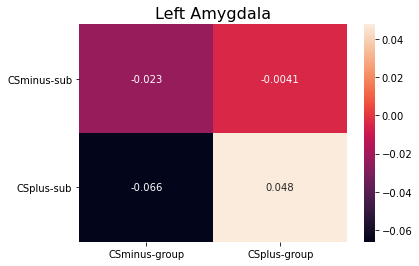

In [7]:
# Compute interSC 
disp_name = 'Left Amygdala'
classical_data = [None] * nCohort

for i in range(nCohort):
    classical_data[i] = np.load(work_dir +
                                '/data/neural-classical/amygdala-harvard-oxford-6mm/HO_1_6mm/' +
                                cohort_IDs['subject'][i] + '_6mm.npy')

nVoxels = classical_data[0].shape[0]
classical_patterns = np.zeros((nVoxels, 2, nCohort))

for i in range(nCohort):
    classical_patterns[:, 0, i] = np.mean(classical_data[i][:, all_CSminus_onsets[i]], axis = 1)
    classical_patterns[:, 1, i] = np.mean(classical_data[i][:, all_CSplus_onsets[i]], axis = 1)
    
subs = np.arange(0, nCohort)
classical_heldout = np.zeros_like(classical_patterns)
    
for i in subs:
    sel_subs = subs[subs!= i]
    classical_heldout[:, :, i] = np.mean(classical_patterns[:, :, sel_subs], axis = 2)
    
all_mats = np.zeros((2, 2, nCohort))
LA_interSC = np.zeros((2, nCohort))

for i in range(nCohort):
    sub_mat = np.corrcoef(classical_patterns[:,:,i], classical_heldout[:,:,i], rowvar = False)
    sub_mat = sub_mat[:2, 2:]
    all_mats[:,:,i] = sub_mat
    LA_interSC[:, i] = np.diagonal(sub_mat)


# Visualize interSC 
sns.heatmap(np.median(all_mats, axis = 2),
            yticklabels = ['CSminus-sub', 'CSplus-sub'],
            xticklabels = ['CSminus-group', 'CSplus-group'],
            annot = True)

plt.title(disp_name, fontsize = 16)

plt.yticks(rotation = 0)
plt.xticks(rotation = 0) 

plt.savefig(f"{classical_fig_dir}/isc_heatmap.png")

Threat-Threat
median: 0.04755369398265641
iqr: 0.33473338133941033

Threat-Control
median: -0.06607781942756139
iqr: 0.2745728995135778


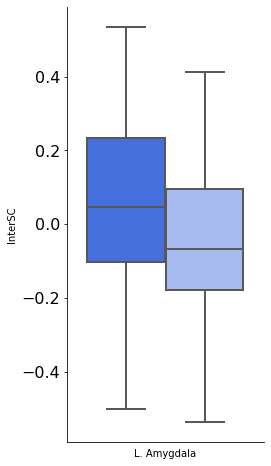

In [8]:
# Calculate and print median interSC values
threat_control_isc = np.zeros(nCohort)
threat_threat_isc = np.zeros(nCohort)

for i in range(nCohort):
    threat_control_isc[i] = all_mats[:,:,i][1,0]
    threat_threat_isc[i] = all_mats[:,:,i][1,1]

threat_threat_med = np.median(threat_threat_isc)
threat_control_med = np.median(threat_control_isc)

threat_threat_iqr = iqr(threat_threat_isc)
threat_control_iqr = iqr(threat_control_isc)

print('Threat-Threat')
print(f"median: {threat_threat_med}")
print(f"iqr: {threat_threat_iqr}")

print('\nThreat-Control')
print(f"median: {threat_control_med}")
print(f"iqr: {threat_control_iqr}")

# Plot interSC values
MvNM_data = pd.DataFrame({'InterSC': list(threat_threat_isc) + list(threat_control_isc),
                          'ROI': ['L. Amygdala'] * nCohort*2,
                          'Scene Type': ['Threat-Threat'] * len(threat_threat_isc) + ['Threat-Control'] * len(threat_control_isc)})

colors = ["#2d63f7", "#9ab4fc"] # define colors for figure palette 

f = plt.figure(figsize=(12, 8))
plt.subplot(131)

ax = sns.boxplot(data = MvNM_data, 
            x = 'ROI', 
            y = 'InterSC', 
            hue = 'Scene Type', 
            linewidth = 2,
            palette = sns.color_palette(colors))


plt.xlabel(None)
ax.tick_params(bottom = False)
plt.yticks(fontsize = 16)
plt.legend([],[], frameon = False)
sns.despine()

plt.savefig(f"{classical_fig_dir}/MvNM_isc.png")


## Discrimination

In [9]:
# Calculate discrimination rate
diff_scores = np.zeros(nCohort)
for i in range(nCohort):
    diff_scores[i] = threat_threat_isc[i] - threat_control_isc[i] 
    logical = diff_scores > 0
disc_rate = sum(logical)/nCohort * 100

# Generate null distribution
null_dist_class = np.zeros(nPerms)

for k in range(nPerms):

    all_classical_patterns = np.zeros((nVoxels, 2, nCohort))

    for i in range(nCohort):

        concat_CS = np.asarray(all_CSminus_onsets[i] + all_CSplus_onsets[i])
        break_point = len(all_CSminus_onsets[i])
        concat_CS = concat_CS[random.choices(range(len(concat_CS)), k = (len(concat_CS)))]
            
        all_classical_patterns[:, 0, i] = np.mean(classical_data[i][:, concat_CS[:break_point]], axis = 1)
        all_classical_patterns[:, 1, i] = np.mean(classical_data[i][:, concat_CS[break_point:]], axis = 1)

    subs = np.arange(0, nCohort)
    all_classical_heldout = np.zeros_like(all_classical_patterns)

    for i in subs:
        sel_subs = subs[subs!= i]
        all_classical_heldout[:, :, i] = np.mean(all_classical_patterns[:, :, sel_subs], axis = 2)

    all_mats = np.zeros((2, 2, nCohort))

    for i in range(nCohort):
        sub_mat = np.corrcoef(all_classical_patterns[:,:,i], all_classical_heldout[:,:,i], rowvar = False)
        all_mats[:,:,i] = sub_mat[:2, 2:]
        
    # Discrimination
    diff_scores = np.zeros(nCohort)

    for i in range(nCohort):
        shuff_threat_control_isc = all_mats[:,:,i][1,0]
        shuff_isc_plus = all_mats[:,:,i][1,1]
        diff_scores[i] = shuff_isc_plus - shuff_threat_control_isc 
        logical = diff_scores > 0
    
    null_dist_class[k] = (sum(logical)/nCohort * 100)
    
# Calculate p-value for classification accuracy
disc_p_val = len((null_dist_class[null_dist_class > disc_rate]) + 1) / (nPerms + 1)

discrimination rate = 67.39%
discrimination p-value = 0.0


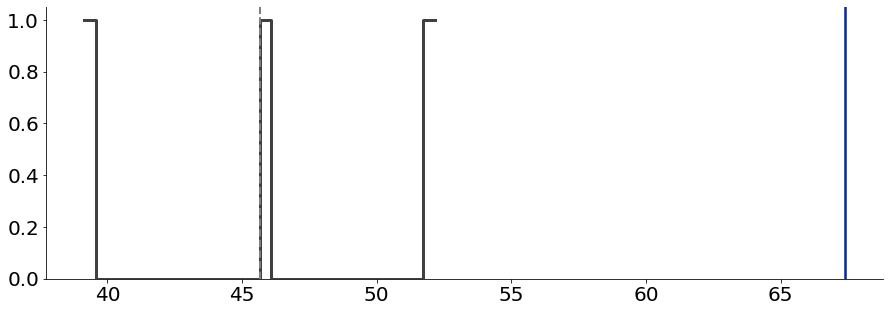

In [10]:
# Display discrimination rate and p-value 
print(f"discrimination rate = {np.round(disc_rate, 2)}%")
print(f"discrimination p-value = {np.round(disc_p_val, 8)}")

f = plt.figure(figsize=(15, 5))
sns.histplot(data = null_dist_class, color = '0.25', fill = False, element = 'step', bins = 30, linewidth = 3)
plt.axvline(disc_rate, color = '#032a94', linewidth = 2.5)
plt.axvline(np.mean(null_dist_class), color = '0.5', linestyle = 'dashed', linewidth = 2)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel(None)
sns.despine()

plt.savefig(f"{classical_fig_dir}/discrimination_histogram.png")

## Left Amygdala InterSC vs. Symptom Severity

In [11]:
# Correlate interSC with hyperarousal severity
print(f"{disp_name} Spatial InterSC vs. Hyperarousal \n")
symptom_labels = ['Hyperarousal']
LA_r_vals, LA_p_vals, LA_nulls =  corr_isc_symp(threat_threat_isc, CAPS_data)

summary = pd.DataFrame()
summary['score'] = symptom_labels
summary['r_vals'] = LA_r_vals
summary['p_vals'] = LA_p_vals

print(summary.to_string())

Left Amygdala Spatial InterSC vs. Hyperarousal 

          score    r_vals  p_vals
0  Hyperarousal -0.072421     0.5


In [12]:
# Correlate interSC with all CAPS symptom severity
print(f"{disp_name} Spatial InterSC vs. All Symptoms \n")
symptom_labels = ['Re-experiencing', 'Avoidance-Numbing', 'Hyperarousal']
LA_r_vals, LA_p_vals, LA_nulls =  corr_isc_symp(threat_threat_isc, CAPS_data)

summary = pd.DataFrame()
summary['score'] = symptom_labels
summary['r_vals'] = LA_r_vals
summary['p_vals'] = LA_p_vals
summary['p_corrected'] = fdrcorrection(LA_p_vals)[1]

print(summary.to_string())

Left Amygdala Spatial InterSC vs. All Symptoms 

               score    r_vals  p_vals  p_corrected
0    Re-experiencing -0.266515     0.5         0.75
1  Avoidance-Numbing -0.203680     0.5         0.75
2       Hyperarousal -0.072421     1.0         1.00


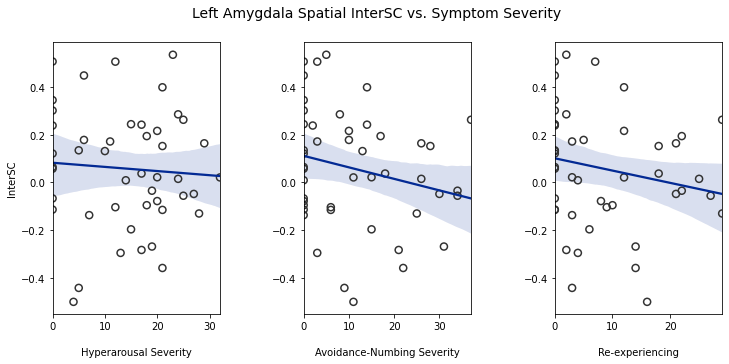

In [13]:
# Plot interSC vs. symptom severity
f = plt.figure(figsize=(12, 5))
f.suptitle('Left Amygdala Spatial InterSC vs. Symptom Severity', fontsize = 14)
plt.subplots_adjust(wspace=0.5, hspace=0.25)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)

ax1 = plt.subplot(131)
x = CAPS_data['Hyperarousal']
y = threat_threat_isc

sns.regplot(x = x, y = y, scatter = False, line_kws = {"color": "#032a94"}).set(xlabel = '\nHyperarousal Severity')
plt.scatter(x, y, s = 50, facecolors = 'none', edgecolors = '0.2', linewidth = 1.5)
plt.ylabel('InterSC')

ax2 = plt.subplot(132, sharey = ax1)
x = CAPS_data['Avoidance-Numbing']
y = threat_threat_isc

sns.regplot(x = x, y = y, scatter = False, line_kws = {"color": "#032a94"}).set(xlabel = '\nAvoidance-Numbing Severity')
plt.scatter(x, y, s = 50, facecolors = 'none', edgecolors = '0.2', linewidth = 1.5)

ax3 = plt.subplot(133, sharey = ax1)
x = CAPS_data['Re-experiencing']
y = threat_threat_isc

sns.regplot(x = x, y = y, scatter = False, line_kws = {"color": "#032a94"}).set(xlabel = '\nRe-experiencing')
plt.scatter(x, y, s = 50, facecolors = 'none', edgecolors = '0.2', linewidth = 1.5)

plt.savefig(f"{classical_fig_dir}/isc_v_symptoms.png")
